In [1]:
import sys,os,argparse,time
import numpy as np
import torch
import utils
from datetime import datetime
import pickle
import pandas as pd
tstart=time.time()
import matplotlib.pyplot as plt 
from tabulate import tabulate
from prettytable import PrettyTable

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# Arguments
parser=argparse.ArgumentParser(description='xxx')
parser.add_argument('--seed',               default=0,                          type=int,     help='(default=%(default)d)')
parser.add_argument('--device',             default='cpu',                      type=str,     help='gpu id')
parser.add_argument('--n_tasks',            default= 16,                         type =int,    help='1, 2 or 16, referring to tasks')
parser.add_argument('--approach',           default='UCB',                      type =str,    help='Method, always Lifelong Uncertainty-aware learning')
parser.add_argument('--test_data_path',     default='data/data_test.csv',       type=str,     help='gpu id')
parser.add_argument('--training_data_path', default='data/data_train.csv',      type=str,     help='gpu id')
parser.add_argument('--output',             default='',                         type=str,     help='')
parser.add_argument('--checkpoint_dir',     default='../checkpoints',           type=str,     help='')
parser.add_argument('--batch_size',         default=64,                         type=int,     help='')
parser.add_argument('--parameter',          default='',                         type=str,     help='')
parser.add_argument('--n_epochs',           default=200,                        type=int,     help='')
parser.add_argument('--lr',                 default=0.06,                       type=float,   help='')
parser.add_argument('--hidden_size',        default=800,                        type=int,     help='')

# Bayesian HYPER-PARAMETERS
parser.add_argument('--MC_samples',         default='10',           type=int,     help='Number of Monte Carlo samples')
parser.add_argument('--rho',                default='-3',           type=float,   help='Initial rho')
parser.add_argument('--sigma1',             default='0.0',          type=float,   help='STD foor the 1st prior pdf in scaled mixture Gaussian')
parser.add_argument('--sigma2',             default='6.0',          type=float,   help='STD foor the 2nd prior pdf in scaled mixture Gaussian')
parser.add_argument('--pi',                 default='0.25',         type=float,   help='weighting factor for prior')

parser.add_argument('--resume',             default='no',           type=str,     help='resume?')
parser.add_argument('--sti',                default=0,              type=int,     help='starting task?')

parser.add_argument("-f", "--fff", help="a dummy argument to fool ipython", default="1")

args=parser.parse_args()
#utils.print_arguments(args)

In [4]:
# Set seed for stable results
#np.random.seed(args.seed)
#torch.manual_seed(args.seed)

# Import training approach:
from UCB_modified import UCB

# Import model used:
from bayesian_model.bayesian_network import BayesianNetwork

# Load data to get input and output sizes:
# Determine dataloader
if args.n_tasks == 1:
    # Load data:
    from data import dataloader_1_tasks as train_dataloader
    from data import dataloader_1_tasks_test as test_dataloader
elif args.n_tasks == 2:
    # Load data:
    from data import dataloader_2_tasks as train_dataloader
    from data import dataloader_2_tasks_test as test_dataloader
else:
    # Load data:
    from data import dataloader_16_tasks as train_dataloader
    from data import dataloader_16_tasks_test as test_dataloader
# Load data  
data_train, task_outputs, input_size = train_dataloader.get(data_path=args.training_data_path)
args.num_tasks = len(task_outputs)
args.input_size = input_size
args.task_outputs = task_outputs

# Load features to get file path for screenshots:
df_x1 = pd.read_csv('/Users/jonastjomsland/Dissertation/scripts_and_data/features4.csv')
df_x1 = df_x1.iloc[:, :-1]
df_x2 = pd.read_csv('/Users/jonastjomsland/Dissertation/data/features5.csv', sep=';')
df_x2.columns = df_x2.iloc[0]
df_x2 = df_x2.drop(df_x2.index[0])
df_x2 = df_x2.iloc[:, :-1]
features = pd.concat([df_x1, df_x2])
features = features.iloc[:-40,:-12]
features['Stamp'] = features['Stamp'].astype(int)
file_paths = features['File Path'].values

# Add to experiment name if testing:
#args.approach += '_untrained_'

# Checkpoint for stored model
checkpoint = utils.make_directories(args)
args.checkpoint = checkpoint

# Initialize Bayesian network
model = BayesianNetwork(args).to(args.device)

# Initialize UCB
approach = UCB(model, args=args)

Results will be saved in  ../checkpoints/16_UCB


In [5]:
# Load test data:
full_set = pd.read_csv(args.test_data_path)
full_set['Stamp'] = full_set['Stamp'].astype(int)
# Split in circle and arrow
df_circle = full_set[full_set['Using circle'] == 1]
df_arrow = full_set[full_set['Using circle'] == 0]
actions = [['Vacuum cleaning', 'Mopping the floor', 'Carry warm food', 'Carry cold food', 'Carry drinks', 'Carry small objects (plates, toys)', 'Carry big objects (tables, chairs)', 'Cleaning (Picking up stuff)'], ['Vacuum cleaning', 'Mopping the floor', 'Carry warm food', 'Carry cold food', 'Carry drinks', 'Carry small objects (plates, toys)', 'Carry big objects (tables, chairs)', 'Starting conversation']]
scenes_circle = df_circle['Stamp'].unique()
scenes_arrow = df_arrow['Stamp'].unique()
# Update file paths
for scene in scenes_circle:
    file_paths[scene-250] = '/Users/jonastjomsland/Dissertation/' + file_paths[scene-250]
for scene in scenes_arrow:
    file_paths[scene-250] = '/Users/jonastjomsland/Dissertation/' + file_paths[scene-250]

In [6]:
# Load stored model:
if args.n_tasks == 16:
    model_number = 0
elif args.n_tasks == 2:
    model_number = 1
else:
    model_number = 0

epistemic_circle = np.zeros((8,17))
epistemic_circle[:,0] = [0.195, 0.193, 0.223, 0.227, 0.229, 0.199, 0.196, 0.195]
aleatoric_circle = np.zeros((8,17))
aleatoric_circle[:,0] = [0.544, 1.018, 0.816, 0.922, 0.912, 2.913, 0.289, 0.881] 
epistemic_arrow = np.zeros((8,17))
epistemic_arrow[:,0] = [0.237, 0.249, 0.235, 0.199, 0.205, 0.187, 0.221, 0.233]
aleatoric_arrow = np.zeros((8,17))
aleatoric_arrow[:,0] = [0.751, 0.732, 1.359, 0.973, 1.746, 1.146, 2.473, 0.596]
mean_ale_circle_trained = []
mean_ale_circle= []
mean_ale_arrow = []
mean_ale_arrow_trained = []
mean_epi_circle = []
mean_epi_circle_trained = []
mean_epi_arrow = []
mean_epi_arrow_trained = []

    
for model_number in np.arange(0,16):
    checkpoint = torch.load(os.path.join(args.checkpoint, 'model_{}.pth.tar'.format(model_number)), map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device=args.device).eval()

    # Determine input
    input_circle = torch.tensor(df_circle.iloc[:,0:30].drop_duplicates().values).type(torch.float32)[:,1:]
    input_arrow = torch.tensor(df_arrow.iloc[:,0:30].drop_duplicates().values).type(torch.float32)[:,1:]
    # Initialise empty array to store mean and log variance
    mean_output_circle = np.empty((input_circle.shape[0],8), float)
    logvar_output_circle = np.empty((input_circle.shape[0],8), float)
    mean_output_arrow = np.empty((input_arrow.shape[0],8), float)
    logvar_output_arrow = np.empty((input_arrow.shape[0],8), float)
    # Do 100 MC samples:
    for sample in range(100):
        # Handle the three different model outputs differently
        # 1 task model
        if args.n_tasks == 1:
            # Get output
            output_circle = model(input_circle, sample = True, sample_last_layer = True)
            output_arrow = model(input_arrow, sample = True, sample_last_layer = True)
            mean_output_circle = np.dstack((mean_output_circle, output_circle[0][:,0:8].detach().numpy()))
            logvar_output_circle =  np.dstack((logvar_output_circle, output_circle[0][:,16:24].detach().numpy()))
            mean_output_arrow =  np.dstack((mean_output_arrow, output_arrow[0][:,8:16].detach().numpy()))
            logvar_output_arrow =  np.dstack((logvar_output_arrow, output_arrow[0][:,24:].detach().numpy()))
        # 2 tasks model
        elif args.n_tasks == 2:
            # Get output
            output_circle = model(input_circle, sample = False, sample_last_layer = True)[0]
            output_arrow = model(input_arrow, sample = False, sample_last_layer = True)[1]
            mean_output_circle =  np.dstack((mean_output_circle, output_circle[:,0:8].detach().numpy()))
            logvar_output_circle =  np.dstack((logvar_output_circle, output_circle[:,8:].detach().numpy()))
            mean_output_arrow =  np.dstack((mean_output_arrow,output_arrow[:,0:8].detach().numpy()))
            logvar_output_arrow =  np.dstack((logvar_output_arrow,output_arrow[:,8:].detach().numpy()))
        # 16 tasks model
        else:
            # Get output
            output_circle = model(input_circle, sample = False, sample_last_layer = True)
            output_arrow = model(input_arrow, sample = False, sample_last_layer = True)
            # Temporary matrices  
            tmp_circle_mean = np.empty((input_circle.shape[0],8), float)
            tmp_circle_logvar = np.empty((input_circle.shape[0],8), float)
            tmp_arrow_mean = np.empty((input_arrow.shape[0],8), float)
            tmp_arrow_logvar =  np.empty((input_arrow.shape[0],8), float)
            # Fill with predictions:
            for i, prediction in enumerate(output_circle[0:8]):
                tmp_circle_mean[:,i] =  prediction[:,0].detach().numpy()
                tmp_circle_logvar[:,i] =  prediction[:,1].detach().numpy()
            for i, prediction in enumerate(output_arrow[8:]):
                tmp_arrow_mean[:,i] =  prediction[:,0].detach().numpy()
                tmp_arrow_logvar[:,i] =  prediction[:,1].detach().numpy()
            # Stack 
            mean_output_circle =  np.dstack((mean_output_circle,tmp_circle_mean))
            logvar_output_circle =  np.dstack((logvar_output_circle, tmp_circle_logvar))
            mean_output_arrow =  np.dstack((mean_output_arrow,tmp_arrow_mean))
            logvar_output_arrow =  np.dstack((logvar_output_arrow,tmp_arrow_logvar))
    # Remove first empty dimension
    mean_output_circle =  mean_output_circle[:,:,1:]
    var_output_circle =  np.exp(logvar_output_circle[:,:,1:])
    mean_output_arrow =  mean_output_arrow[:,:,1:]
    var_output_arrow =  np.exp(logvar_output_arrow[:,:,1:])


    # Dictionary for dataframes:
    df_dict = {}
    df_dict['DataFrames'] = {}
    df_dict['Averaged uncertainties'] = {}
    # Circle actions
    for scene_id, scene in enumerate(scenes_circle):
        df_dict['DataFrames'][scene] = pd.DataFrame(columns = actions[0], index = ['Label mean', 'Predicted mean', 'Label variance', 'Aleatoric uncertainty', 'Epistemic uncertainty'])
        scene_df = df_circle[df_circle.Stamp == scene].iloc[:,-8:].reset_index().iloc[:,1:]
        df_dict['DataFrames'][scene].loc['Label mean', :] = np.round(scene_df.mean().values,2)
        df_dict['DataFrames'][scene].loc['Label variance', :] = np.round(scene_df.var().values,2)
        df_dict['DataFrames'][scene].loc['Predicted mean', :] = np.round(np.mean(mean_output_circle[scene_id,:,:], axis = 1), 2)
        df_dict['DataFrames'][scene].loc['Aleatoric uncertainty', :] = np.round(np.mean(var_output_circle[scene_id,:,:], axis = 1), 2)
        df_dict['DataFrames'][scene].loc['Epistemic uncertainty', :] = np.round(np.mean(np.square(mean_output_circle[scene_id,:,:]), axis = 1) - np.square(np.mean(mean_output_circle[scene_id,:,:], axis = 1)), 2)
        df_dict['Averaged uncertainties'][scene] = {}
        df_dict['Averaged uncertainties'][scene]['Aleatoric'] = np.mean(df_dict['DataFrames'][scene].loc['Aleatoric uncertainty', :])
        df_dict['Averaged uncertainties'][scene]['Epistemic'] = np.mean(df_dict['DataFrames'][scene].loc['Epistemic uncertainty', :])

    # Arrow actions 
    for scene_id, scene in enumerate(scenes_arrow):
        df_dict['DataFrames'][scene] = pd.DataFrame(columns = actions[1], index = ['Label mean', 'Predicted mean', 'Label variance', 'Aleatoric uncertainty', 'Epistemic uncertainty'])
        scene_df = df_arrow[df_arrow.Stamp == scene].iloc[:,-8:].reset_index().iloc[:,1:]
        df_dict['DataFrames'][scene].loc['Label mean', :] = np.round(scene_df.mean().values,2)
        df_dict['DataFrames'][scene].loc['Label variance', :] = np.round(scene_df.var().values,2)
        df_dict['DataFrames'][scene].loc['Predicted mean', :] = np.round(np.mean(mean_output_arrow[scene_id,:,:], axis = 1), 2)
        df_dict['DataFrames'][scene].loc['Aleatoric uncertainty', :] = np.round(np.mean(var_output_arrow[scene_id,:,:], axis = 1), 2)
        df_dict['DataFrames'][scene].loc['Epistemic uncertainty', :] = np.round(np.mean(np.square(mean_output_arrow[scene_id,:,:]), axis = 1) - np.square(np.mean(mean_output_arrow[scene_id,:,:], axis = 1)), 2)
        df_dict['Averaged uncertainties'][scene] = {}
        df_dict['Averaged uncertainties'][scene]['Aleatoric'] = np.mean(df_dict['DataFrames'][scene].loc['Aleatoric uncertainty', :])
        df_dict['Averaged uncertainties'][scene]['Epistemic'] = np.mean(df_dict['DataFrames'][scene].loc['Epistemic uncertainty', :])

    epi_circle = []
    ale_circle = []
    sqrd_diff_circle = np.empty((1,8))
    per_action_epi_circle = np.empty((1,8))
    per_action_ali_circle = np.empty((1,8))
    for scene in scenes_circle:
        #print(scene)
        #display(df_dict['DataFrames'][scene].iloc[0:2,:])
        #img = plt.imread(file_paths[scene-250])
        #plt.figure(figsize = (10,12))
        #plt.axis('off')
        #imgplot = plt.imshow(img)
        #plt.show()
        ale_circle.append(df_dict['Averaged uncertainties'][scene]['Aleatoric'])
        epi_circle.append(df_dict['Averaged uncertainties'][scene]['Epistemic'])
        sqrd_diff_circle = np.vstack((sqrd_diff_circle, (np.square(df_dict['DataFrames'][scene].loc['Predicted mean', :]-df_dict['DataFrames'][scene].loc['Label mean', :]))))
        per_action_ali_circle = np.vstack((per_action_ali_circle, df_dict['DataFrames'][scene].loc['Aleatoric uncertainty', :]))
        per_action_epi_circle = np.vstack((per_action_epi_circle, df_dict['DataFrames'][scene].loc['Epistemic uncertainty', :]))
    #print(25*'-' + ' Circle actions ' + 25*'-')
    #print('Aleatoric circle: ', np.round(np.mean(ale_circle),4))
    #print('Epistemic circle: ', np.round(np.mean(epi_circle),4))
    sqrd_diff_circle = sqrd_diff_circle[1:,:]
    per_action_ali_circle = per_action_ali_circle[1:,:]
    per_action_epi_circle = per_action_epi_circle[1:,:]
    #print('RSME circle: ', np.round(np.sqrt(np.mean(sqrd_diff_circle, axis = 0).astype(float)),3))
    #print('Per circle action aleatoric: ', np.round(np.mean(per_action_ali_circle, axis = 0).astype(float), 3))
    #print('Per circle action epistemic: ', np.round(np.mean(per_action_epi_circle, axis = 0).astype(float), 3))
    
    epistemic_circle[:,model_number+1] = np.round(np.mean(per_action_epi_circle, axis = 0).astype(float), 3)
    aleatoric_circle[:,model_number+1] = np.round(np.mean(per_action_ali_circle, axis = 0).astype(float), 3)
    
    if model_number > 7:
        trained_index = 7
    else:
        trained_index = model_number

    mean_epi_circle.append(np.mean(epi_circle[trained_index:]))
    mean_epi_circle_trained.append(np.mean(epi_circle[0:trained_index+1]))
    mean_ale_circle.append(np.mean(ale_circle[trained_index:]))
    mean_ale_circle_trained.append(np.mean(ale_circle[0:trained_index+1]))
    
    
    epi_arrow = []
    ale_arrow = []
    sqrd_diff_arrow = np.empty((1,8))
    per_action_epi_arrow = np.empty((1,8))
    per_action_ali_arrow = np.empty((1,8))    
    for scene in scenes_arrow:
        #print(scene)
        #display(df_dict['DataFrames'][scene].iloc[0:2,:])
        #img = plt.imread(file_paths[scene-250])
        #plt.figure(figsize = (10,12))
        #plt.axis('off')
        #imgplot = plt.imshow(img)
        #plt.show()
        ale_arrow.append(df_dict['Averaged uncertainties'][scene]['Aleatoric'])
        epi_arrow.append(df_dict['Averaged uncertainties'][scene]['Epistemic'])
        sqrd_diff_arrow = np.vstack((sqrd_diff_arrow, (np.square(df_dict['DataFrames'][scene].loc['Predicted mean', :]-df_dict['DataFrames'][scene].loc['Label mean', :]))))
        per_action_ali_arrow = np.vstack((per_action_ali_arrow, df_dict['DataFrames'][scene].loc['Aleatoric uncertainty', :]))
        per_action_epi_arrow = np.vstack((per_action_epi_arrow, df_dict['DataFrames'][scene].loc['Epistemic uncertainty', :]))
    #print(25*'-' + ' Arrow actions ' + 25*'-')
    #print('Aleatoric arrow: ', np.round(np.mean(ale_arrow),4))
    #print('Epistemic arrow: ', np.round(np.mean(epi_arrow),4))
    sqrd_diff_arrow = sqrd_diff_arrow[1:,:]
    per_action_ali_arrow = per_action_ali_arrow[1:,:]
    per_action_epi_arrow = per_action_epi_arrow[1:,:]
    #print('RSME arrow: ', np.round(np.sqrt(np.mean(sqrd_diff_arrow, axis = 0).astype(float)),3))
    #print('Per arrow action aleatoric: ', np.round(np.mean(per_action_ali_arrow, axis = 0).astype(float), 3))
    #print('Per arrow action epistemic: ', np.round(np.mean(per_action_epi_arrow, axis = 0).astype(float), 3))

    epistemic_arrow[:,model_number+1] = np.round(np.mean(per_action_epi_arrow, axis = 0).astype(float), 3)
    aleatoric_arrow[:,model_number+1] = np.round(np.mean(per_action_ali_arrow, axis = 0).astype(float), 3)
    if model_number < 8:
        trained_index = 0
    else:
        trained_index = model_number - 8
    mean_epi_arrow.append(np.mean(per_action_epi_arrow[trained_index:]))
    mean_epi_arrow_trained.append(np.mean(per_action_epi_arrow[0:trained_index+1]))
    mean_ale_arrow.append(np.mean(per_action_ali_arrow[trained_index:]))
    mean_ale_arrow_trained.append(np.mean(per_action_ali_arrow[0:trained_index+1]))


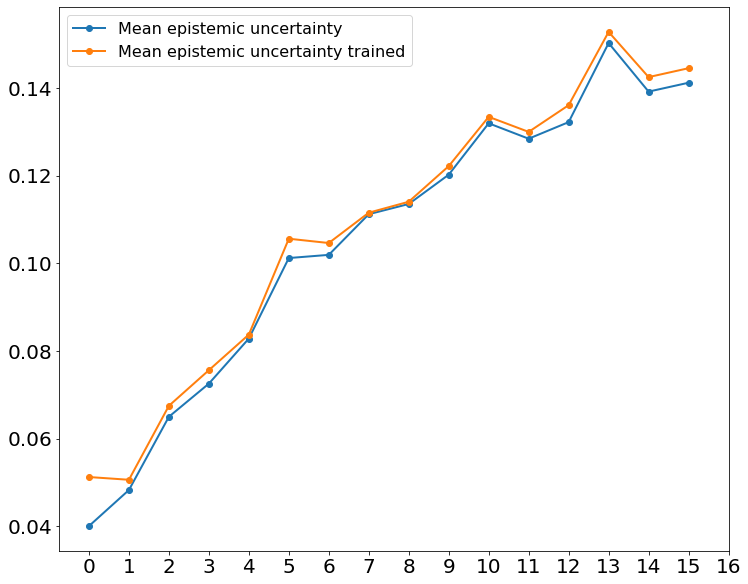

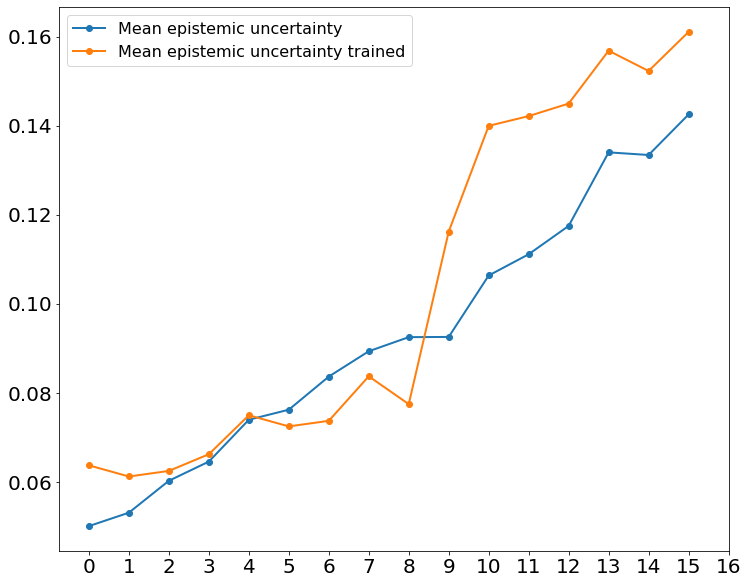

In [7]:
plt.figure(figsize = [12, 10])
plt.plot(np.arange(0,16), mean_epi_circle, '-o', lw = 2, ms = 6, label = 'Mean epistemic uncertainty')
plt.plot(np.arange(0,16), mean_epi_circle_trained, '-o', lw = 2, ms = 6, label = 'Mean epistemic uncertainty trained')
plt.legend(prop={'size': 16})
plt.xticks(np.arange(0,17), fontsize=20)
plt.yticks(fontsize=20)
plt.show()

plt.figure(figsize = [12, 10])
plt.plot(np.arange(0,16), mean_epi_arrow, '-o', lw = 2, ms = 6, label = 'Mean epistemic uncertainty')
plt.plot(np.arange(0,16), mean_epi_arrow_trained, '-o', lw = 2, ms = 6, label = 'Mean epistemic uncertainty trained')
plt.legend(prop={'size': 16})
plt.xticks(np.arange(0,17), fontsize=20)
plt.yticks(fontsize=20)
plt.show()

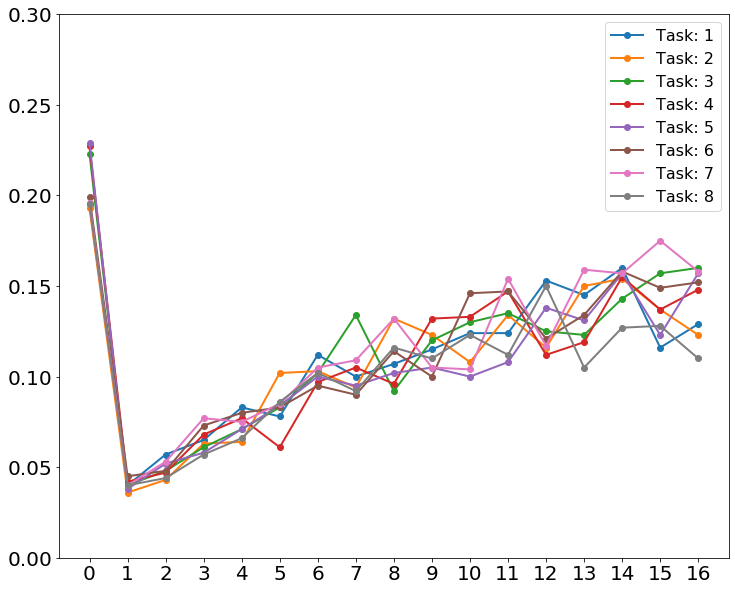

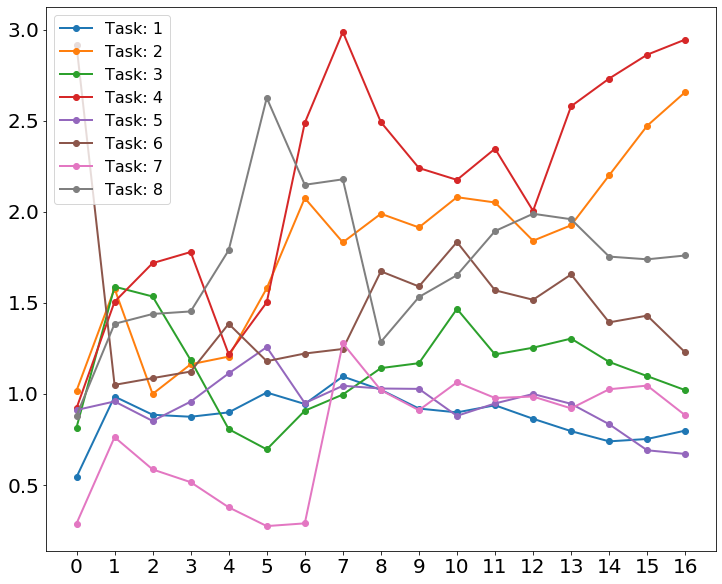

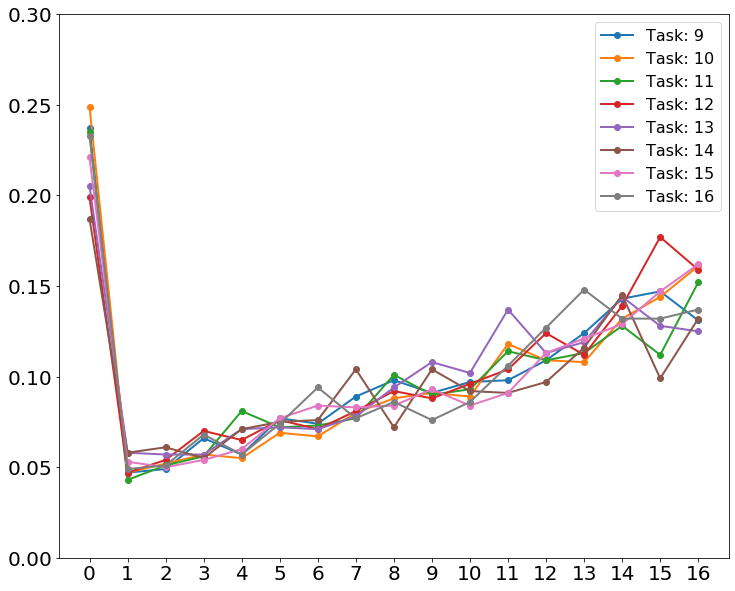

In [8]:
# Circle
#Epi:
plt.figure(figsize = [12, 10])
for task in np.arange(0,8):
    plt.plot(np.arange(0,17), epistemic_circle[task,:], '-o', lw = 2, ms = 6, label = 'Task: ' + str(task+1))
plt.legend(prop={'size': 16})
plt.ylim([0,0.3])
plt.xticks(np.arange(0,17), fontsize=20)
plt.yticks(fontsize=20)
plt.show()

plt.figure(figsize = [12, 10])
for task in np.arange(0,8):
    plt.plot(np.arange(0,17), aleatoric_circle[task,:], '-o', lw = 2, ms = 6, label = 'Task: ' + str(task+1))
plt.legend(prop={'size': 16})
plt.xticks(np.arange(0,17), fontsize=20)
plt.yticks(fontsize=20)
plt.show()



# Arrow
#Epi:
plt.figure(figsize = [12, 10])
for task in np.arange(0,8):
    plt.plot(np.arange(0,17), epistemic_arrow[task,:], '-o', lw = 2, ms = 6, label = 'Task: ' + str(task+9))
plt.legend(prop={'size': 16})
plt.xticks(np.arange(0,17), fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([0,0.3])
plt.show()



No handles with labels found to put in legend.


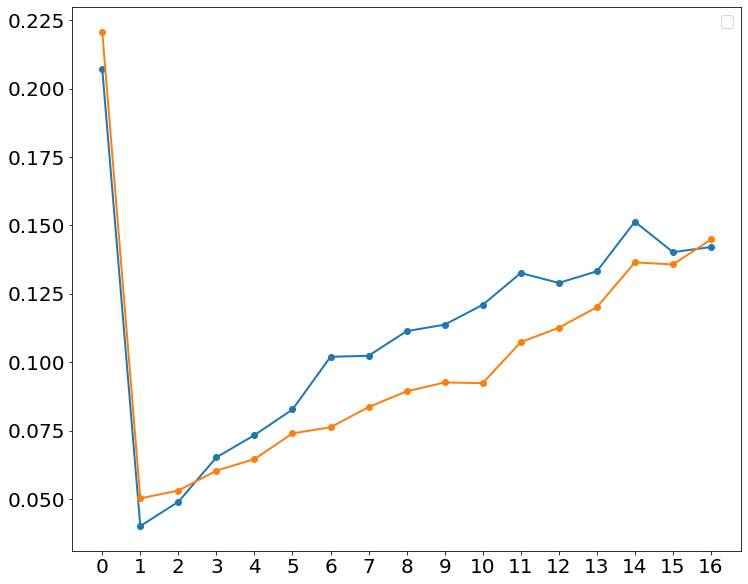

No handles with labels found to put in legend.


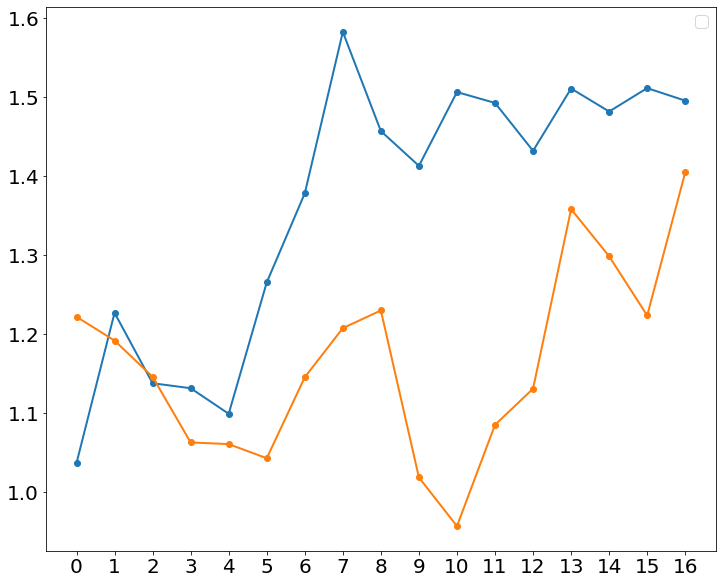

In [9]:
epistemic_circle_mean = np.mean(epistemic_circle, axis = 0)
epistemic_arrow_mean = np.mean(epistemic_arrow, axis = 0)
aleatoric_circle_mean = np.mean(aleatoric_circle, axis = 0)
aleatoric_arrow_mean = np.mean(aleatoric_arrow, axis = 0)

plt.figure(figsize = [12, 10])
plt.plot(np.arange(0,17), epistemic_circle_mean, '-o', lw = 2, ms = 6)
plt.plot(np.arange(0,17), epistemic_arrow_mean, '-o', lw = 2, ms = 6)
plt.legend(prop={'size': 16})
plt.xticks(np.arange(0,17), fontsize=20)
plt.yticks(fontsize=20)
plt.show()

plt.figure(figsize = [12, 10])
plt.plot(np.arange(0,17), aleatoric_circle_mean, '-o', lw = 2, ms = 6)
plt.plot(np.arange(0,17), aleatoric_arrow_mean, '-o', lw = 2, ms = 6)
plt.legend(prop={'size': 16})
plt.xticks(np.arange(0,17), fontsize=20)
plt.yticks(fontsize=20)
plt.show()


In [10]:
print('Epistemic', np.mean([np.round(np.mean(epi_circle),4), np.round(np.mean(epi_arrow),4)]))
print('Aleatoric', np.mean([np.round(np.mean(ale_circle),4), np.round(np.mean(ale_arrow),4)]))
#Epistemic 0.13615
#Aleatoric 1.3197
#Epistemic 0.1843
#Aleatoric 1.32655
#Epistemic 0.22775
#Aleatoric 1.5612


Epistemic 0.14355
Aleatoric 1.4501


In [11]:
print(np.mean([0.44375, 0.4915]))
print(np.mean([0.537625, 0.52275]))
print(np.mean([0.640625, 0.628]))

0.46762499999999996
0.5301875
0.6343125000000001


[[0.099 0.038 0.038 0.062 0.076 0.086 0.095]
 [0.094 0.044 0.044 0.054 0.085 0.095 0.093]
 [0.102 0.042 0.042 0.067 0.094 0.085 0.089]
 [0.102 0.041 0.041 0.054 0.073 0.08  0.093]
 [0.099 0.042 0.042 0.073 0.074 0.094 0.094]
 [0.094 0.037 0.037 0.065 0.064 0.093 0.092]
 [0.09  0.039 0.039 0.066 0.06  0.081 0.087]
 [0.111 0.047 0.047 0.057 0.086 0.094 0.092]]


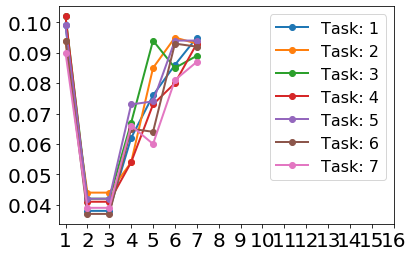

[[0.131 0.052 0.049 0.052 0.067 0.073 0.083]
 [0.092 0.045 0.053 0.058 0.064 0.072 0.074]
 [0.103 0.046 0.052 0.059 0.066 0.066 0.071]
 [0.095 0.048 0.048 0.062 0.071 0.067 0.066]
 [0.105 0.051 0.053 0.061 0.064 0.09  0.081]
 [0.115 0.051 0.051 0.057 0.065 0.071 0.08 ]
 [0.104 0.049 0.053 0.069 0.057 0.069 0.086]
 [0.114 0.046 0.057 0.065 0.062 0.078 0.072]]


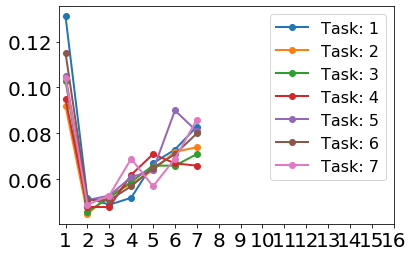

In [12]:
# Circle
epistemics = np.array([[0.099, 0.094, 0.102, 0.102, 0.099, 0.094, 0.09,  0.111],
                       [0.038, 0.044, 0.042, 0.041, 0.042, 0.037, 0.039, 0.047],
                       [0.038, 0.044, 0.042, 0.041, 0.042, 0.037, 0.039, 0.047],
                       [0.062, 0.054, 0.067, 0.054, 0.073, 0.065, 0.066, 0.057], 
                       [0.076, 0.085, 0.094, 0.073, 0.074, 0.064, 0.06,  0.086],
                       [0.086, 0.095, 0.085, 0.08, 0.094, 0.093, 0.081, 0.094],
                       [0.095, 0.093, 0.089, 0.093, 0.094, 0.092, 0.087, 0.092]])
epistemics = epistemics.T
print(epistemics)
for task in np.arange(0,7):
    plt.plot(np.arange(1,8),epistemics[task], '-o', lw = 2, ms = 6, label = 'Task: ' + str(task+1))
plt.legend(prop={'size': 16})
plt.xticks(np.arange(1,17), fontsize=20)
plt.yticks(fontsize=20)
plt.show()

# Arrow
epistemics = np.array([[0.131, 0.092, 0.103, 0.095, 0.105, 0.115, 0.104, 0.114],
                       [0.052, 0.045, 0.046, 0.048, 0.051, 0.051, 0.049, 0.046],
                       [0.049, 0.053, 0.052, 0.048, 0.053, 0.051, 0.053, 0.057],
                       [0.052, 0.058, 0.059, 0.062, 0.061, 0.057, 0.069, 0.065], 
                       [0.067, 0.064, 0.066, 0.071, 0.064, 0.065, 0.057, 0.062],
                       [0.073, 0.072, 0.066, 0.067, 0.09,  0.071, 0.069, 0.078],
                       [0.083, 0.074, 0.071, 0.066, 0.081, 0.08,  0.086, 0.072]])
epistemics = epistemics.T
print(epistemics)
for task in np.arange(0,7):
    plt.plot(np.arange(1,8),epistemics[task], '-o', lw = 2, ms = 6, label = 'Task: ' + str(task+1))
plt.legend(prop={'size': 16})
plt.xticks(np.arange(1,17), fontsize=20)
plt.yticks(fontsize=20)
plt.show()
